# Sunpy and astropy tutorial


Tutorial showing how to work with coordinates and areas selection using astropy routines and sunpy maps. Also we are presenting how to resample a map and how to create a Carrington map.

In [5]:
#We include the libraries needed

import matplotlib.pyplot as plt 
import astropy.units as u
from astropy.coordinates import SkyCoord
import numpy as np
import sunpy.map
import reproject
from astropy.io import fits
from sunpy.coordinates import HeliographicCarrington, HeliographicStonyhurst

In [6]:
%matplotlib inline

### Loading data

In [7]:
#We define the data_dir pathing
#The angle between SDO and SolO was about -20º

data_dir = "data/"

aia_path = data_dir + "aia.lev1_euv_12s.2023-10-31T123146Z.171.image_lev1.fits"
hmi_path_bmag = data_dir + "hmi.ME_720s_fd10.20231031_122400_TAI.field.fits" 
hmi_path_inc = data_dir + "hmi.ME_720s_fd10.20231031_122400_TAI.inclination.fits"
phi_path = data_dir + "mag_raw_20231031T122608.fits"
hri_path = data_dir + "solo_L2_eui-hrieuvopn-image_20231031T122608185_V01.fits"

#Reading data. HMI Blos is calculated as B*cos(inc)
hmi_bmag_data, hmi_header = fits.getdata(hmi_path_bmag, header = True)
hmi_inc_data = fits.getdata(hmi_path_inc, header = False) #We will use the previous header
phi_data, phi_header = fits.getdata(phi_path, header = True)
aia_data, aia_header = fits.getdata(aia_path, header = True)
hri_data, hri_header = fits.getdata(hri_path, header = True)

hmi_data = hmi_bmag_data * np.cos(np.deg2rad(hmi_inc_data))

## Correcting WCS Information in HRT

In [8]:
#adjust HRT wcs 31 Oct 1104
phi_header['CRPIX1'] = phi_header['CRPIX1'] + 20
phi_header['CRPIX2'] = phi_header['CRPIX2'] + 92 #For 17 at 17.45 it is 198


### Create sunpy maps

In [9]:
#Now we define the sunpy maps for HMI, HRT, AIA and HRI. We need to use .rotate() so that the solar north points upwards
#For AIA it is not needed

hmi_map = sunpy.map.Map(hmi_data, hmi_header).rotate()
phi_map = sunpy.map.Map(phi_data, phi_header).rotate()
aia_map = sunpy.map.Map(aia_data, aia_header)
hri_map = sunpy.map.Map(hri_data, hri_header).rotate()

### Plotting data

In [10]:
#plotting details
hmi_map.plot_settings['norm'].vmin = -50
hmi_map.plot_settings['norm'].vmax = 50 
hmi_map.plot_settings['cmap'] = "Greys_r"

phi_map.plot_settings['norm'].vmin = -50
phi_map.plot_settings['norm'].vmax = 50
phi_map.plot_settings['cmap'] = "Greys_r"

Text(0.5, 1.0, 'HRI map')

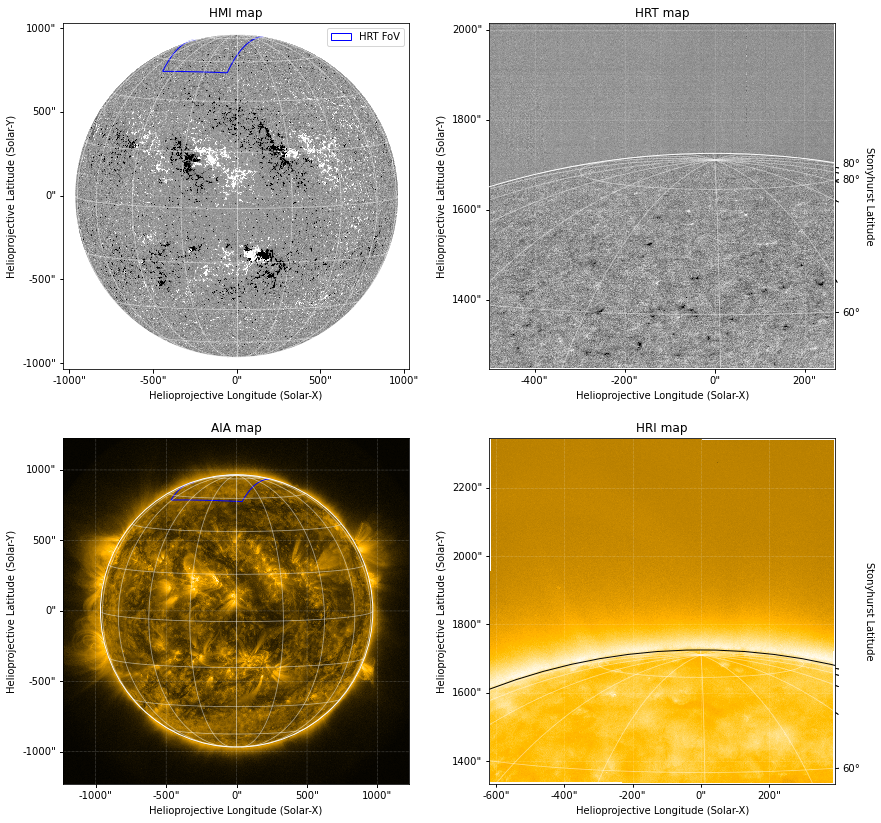

In [11]:
#We plot both maps. The size of the solar disc is different due to the different distance of SDO and Solar Orbiter.
#This size is almost double in FDT because the distance to the Sun of the dataset is about 0.485 AU

fig = plt.figure(figsize = (14,14))

ax1 = fig.add_subplot(221, projection=hmi_map)

hmi_map.plot(axes=ax1)
hmi_map.draw_limb()
hmi_map.draw_grid(grid_spacing = 20 * u.deg)

# Let's plot the FoV of HRT in HMI
hmi_map.draw_quadrangle(phi_map.bottom_left_coord, top_right=phi_map.top_right_coord, edgecolor='blue', label = "HRT FoV") 

plt.legend()
plt.title("HMI map")

ax2 = fig.add_subplot(222, projection=phi_map)

phi_map.plot(axes=ax2)
phi_map.draw_limb()
phi_map.draw_grid(grid_spacing = 20 * u.deg)
plt.title("HRT map")

ax3 = fig.add_subplot(223, projection=aia_map)

aia_map.plot(axes=ax3)
aia_map.draw_limb()
aia_map.draw_grid(grid_spacing = 20 * u.deg)

# Let's plot the FoV of HRI in AIA
aia_map.draw_quadrangle(hri_map.bottom_left_coord, top_right=hri_map.top_right_coord, edgecolor='blue', label = "HRT FoV") 

plt.title("AIA map")

ax4 = fig.add_subplot(224, projection=hri_map)

hri_map.plot(axes=ax4)
hri_map.draw_limb(color = "black")
hri_map.draw_grid(grid_spacing = 20 * u.deg)
plt.title("HRI map")

### Reprojecting HRT onto HMI's FoV

We use the reprojection algorithm present in sunpy, which uses the WCS information within the header of the FITS file, to remap HRT onto the HMI's FOV.

First, we create an out_header using sunpy.map.make_fitswcs_header to be the output of the FDT remapped image.

In [12]:
#Rotate HRT onto HMI plane

repro_header = sunpy.map.make_fitswcs_header(
    phi_map.data.shape,
    hmi_map.reference_coordinate.replicate(rsun=phi_map.reference_coordinate.rsun),
    scale=u.Quantity(phi_map.scale),
    instrument="PHI",
    observatory="HMI Observer"
                                          )

Now we apply the reprojection algorithm. It can take some seconds to finish

In [13]:
hrt_reprojected_hmi = phi_map.reproject_to(repro_header, algorithm = "adaptive")




Normally I reproject the maps using the previous way, but for this HRT map it is not working. I don't know if that is a problem of the WCS or because it is really close to the poles. In any case, I recommend you to use this previous algorithm.

In [14]:
hrt_reprojected_hmi = phi_map.reproject_to(hmi_map.wcs) #Second way of reprojecting
hri_reprojeceted_aia = hri_map.reproject_to(aia_map.wcs) #It seems that this routine also resamples the map cause I am obtaining the same pixels for the data matrix once it is cropped

We plot the reprojected HRT map alongside the original HMI map.

Text(0.5, 1.0, 'HRI projected to AIA FoV')

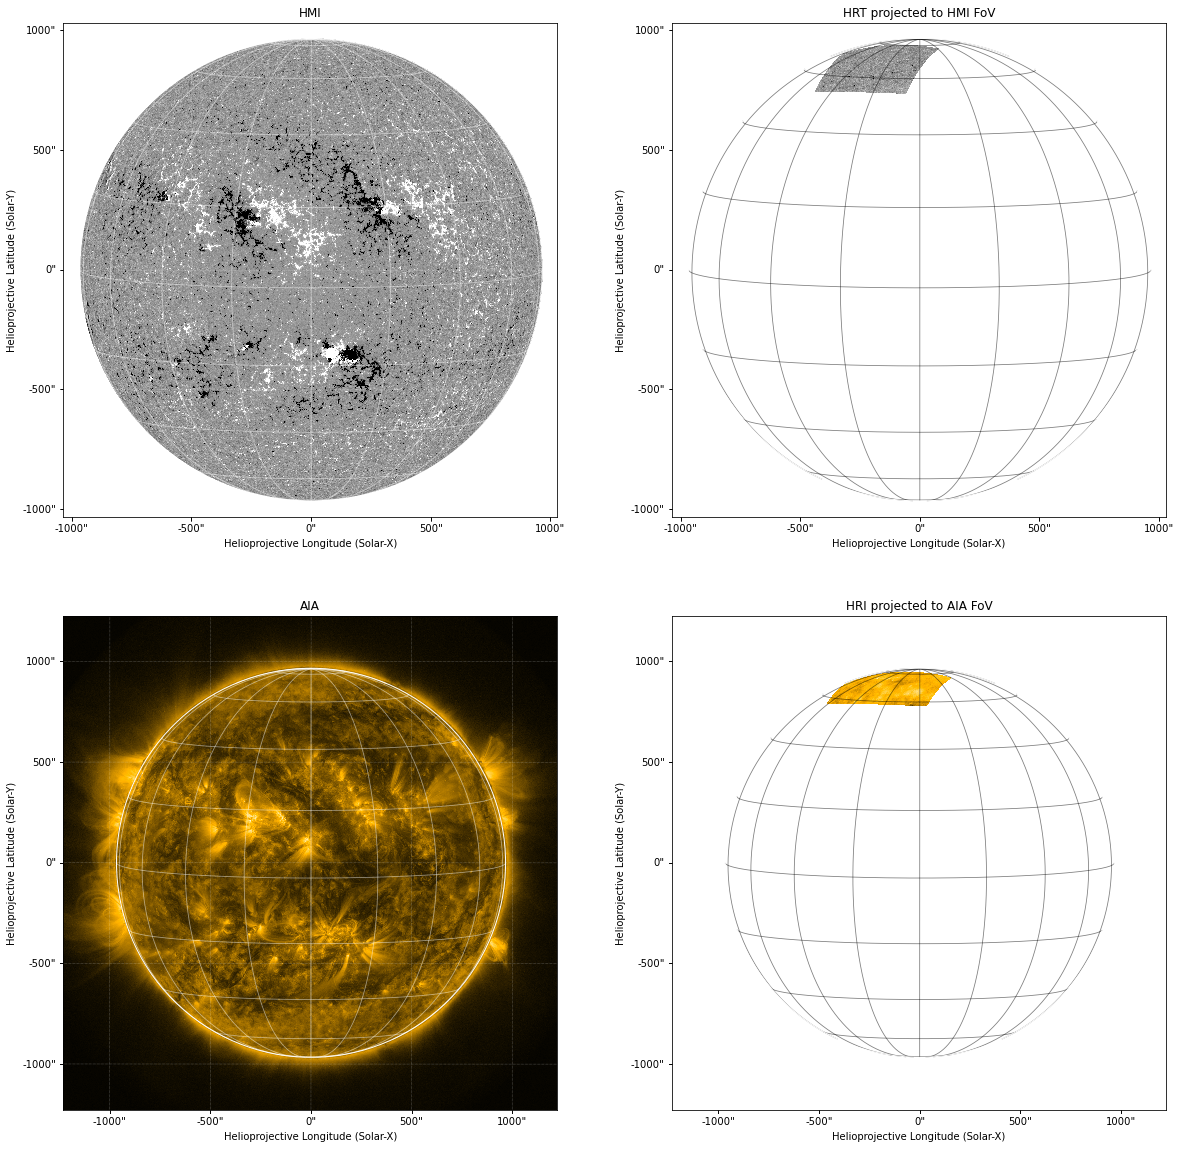

In [15]:
fig = plt.figure(figsize = (20,20))

ax1 = fig.add_subplot(221, projection= hmi_map)

hmi_map.plot(axes=ax1)

hmi_map.draw_limb()
hmi_map.draw_grid(grid_spacing = 20 * u.deg)

plt.title("HMI")

ax2 = fig.add_subplot(222, projection= hrt_reprojected_hmi)

hrt_reprojected_hmi.plot(axes=ax2, title='HRT image as seen from SDO', autoalign = True)

hrt_reprojected_hmi.draw_limb()
hrt_reprojected_hmi.draw_grid(grid_spacing = 20 * u.deg, color = "black")

plt.title("HRT projected to HMI FoV")

ax3 = fig.add_subplot(223, projection= aia_map)

aia_map.plot(axes=ax3)

aia_map.draw_limb()
aia_map.draw_grid(grid_spacing = 20 * u.deg)

plt.title("AIA")

ax4 = fig.add_subplot(224, projection= hri_reprojeceted_aia)

hri_reprojeceted_aia.plot(axes=ax4, title='HRT image as seen from SDO', autoalign = True)

hri_reprojeceted_aia.draw_limb()
hri_reprojeceted_aia.draw_grid(grid_spacing = 20 * u.deg, color = "black")

plt.title("HRI projected to AIA FoV")

### Plot both maps in pixel matrix

In this case, due to the distance of HRT, the pixel size is the same as in HMI, so we do not need to resample (I will show an example later using FDT)

To visualize them, we will try to make them have the same X and Y axis, so we will crop them. In this case, we will create submaps from -470 to 160 arcsec in X and 730 to 950 Y axis


Text(0.5, 1.0, 'HRI')

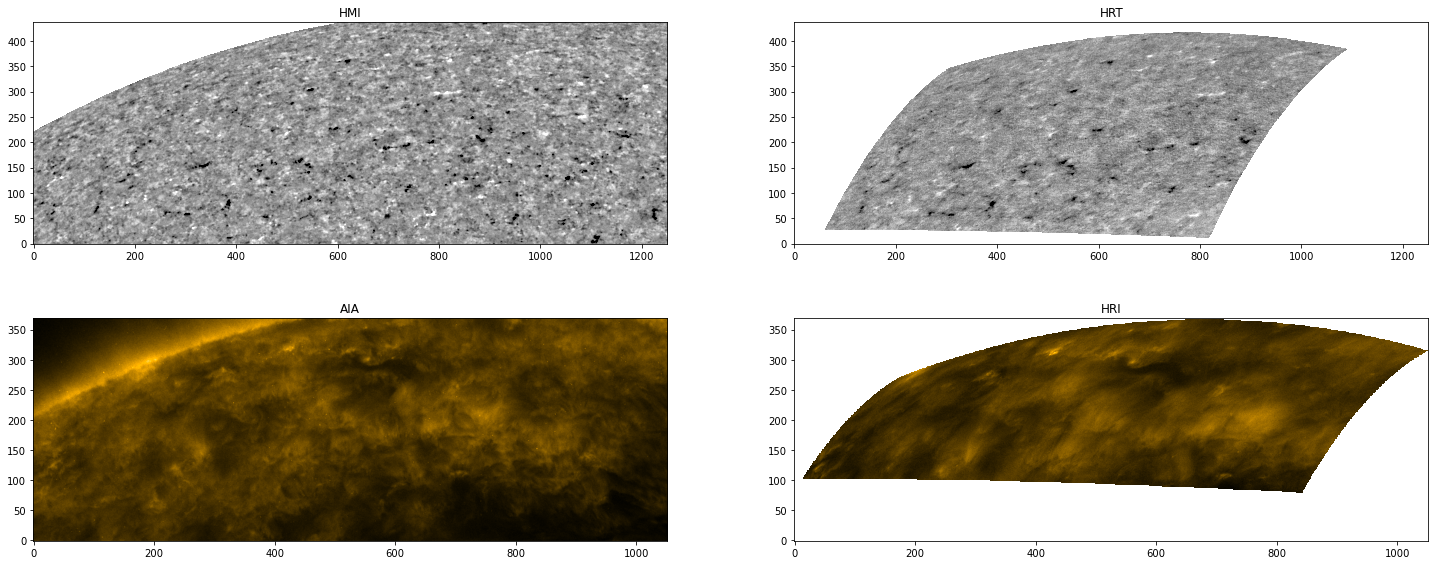

In [16]:
xmin, xmax = -470, 160
ymin, ymax = 730, 950

#First the HMI map
top_right_HMI = SkyCoord(xmax * u.arcsec, ymax * u.arcsec, frame=hmi_map.coordinate_frame)
bottom_left_HMI = SkyCoord(xmin  * u.arcsec, ymin * u.arcsec, frame=hmi_map.coordinate_frame)

hmi_submap = hmi_map.submap(bottom_left_HMI, top_right = top_right_HMI)

#Then the HRT map that previously we reprojected to HMI's FoV. If you do not want to use that you should correct the distance of HRT and set it as 1 AU (Like HMI)
top_right_HRT = SkyCoord(xmax * u.arcsec, ymax * u.arcsec, frame=hrt_reprojected_hmi.coordinate_frame)
bottom_left_HRT = SkyCoord(xmin  * u.arcsec, ymin * u.arcsec, frame=hrt_reprojected_hmi.coordinate_frame)

hrt_reprojected_hmi_submap = hrt_reprojected_hmi.submap(bottom_left_HRT, top_right = top_right_HRT)


#AIA
top_right_aia = SkyCoord(xmax * u.arcsec, ymax * u.arcsec, frame=aia_map.coordinate_frame)
bottom_left_aia = SkyCoord(xmin  * u.arcsec, ymin * u.arcsec, frame=aia_map.coordinate_frame)

aia_submap = aia_map.submap(bottom_left_aia, top_right = top_right_aia)

#HRI
top_right_hri = SkyCoord(xmax * u.arcsec, ymax * u.arcsec, frame=hri_reprojeceted_aia.coordinate_frame)
bottom_left_hri = SkyCoord(xmin  * u.arcsec, ymin * u.arcsec, frame=hri_reprojeceted_aia.coordinate_frame)

hri_reprojected_aia_submap = hri_reprojeceted_aia.submap(bottom_left_hri, top_right = top_right_hri)



fig = plt.figure(figsize = (25,10))

ax = fig.add_subplot(221)
plt.imshow(hmi_submap.data, origin = "lower", cmap = "Greys_r", clim = (-30, 30)) #.data means the data matrix of the maps, with that you can compare pixel by pixel or whatever you need
plt.title("HMI")
ax2 = fig.add_subplot(222)
plt.imshow(hrt_reprojected_hmi_submap.data, origin = "lower", cmap = "Greys_r", clim = (-30, 30))
plt.title("HRT")
ax3 = fig.add_subplot(223)
plt.imshow(aia_submap.data, origin = "lower", cmap = "sdoaia171") #.data means the data matrix of the maps, with that you can compare pixel by pixel or whatever you need
plt.title("AIA")
ax2 = fig.add_subplot(224)
plt.imshow(hri_reprojected_aia_submap.data, origin = "lower", cmap = "sdoaia171")
plt.title("HRI")

### Select the same area in both maps and crop them

Now we will select the same area in latitude and longitued and crop them in case you want to overplot one over the other. To select the area we will use a funcion called draw_quadrangle. We need to create a SkyCoord object with the desired latitude and longitude. 

Text(0.5, 1.18, 'HRI projected to AIA FoV')

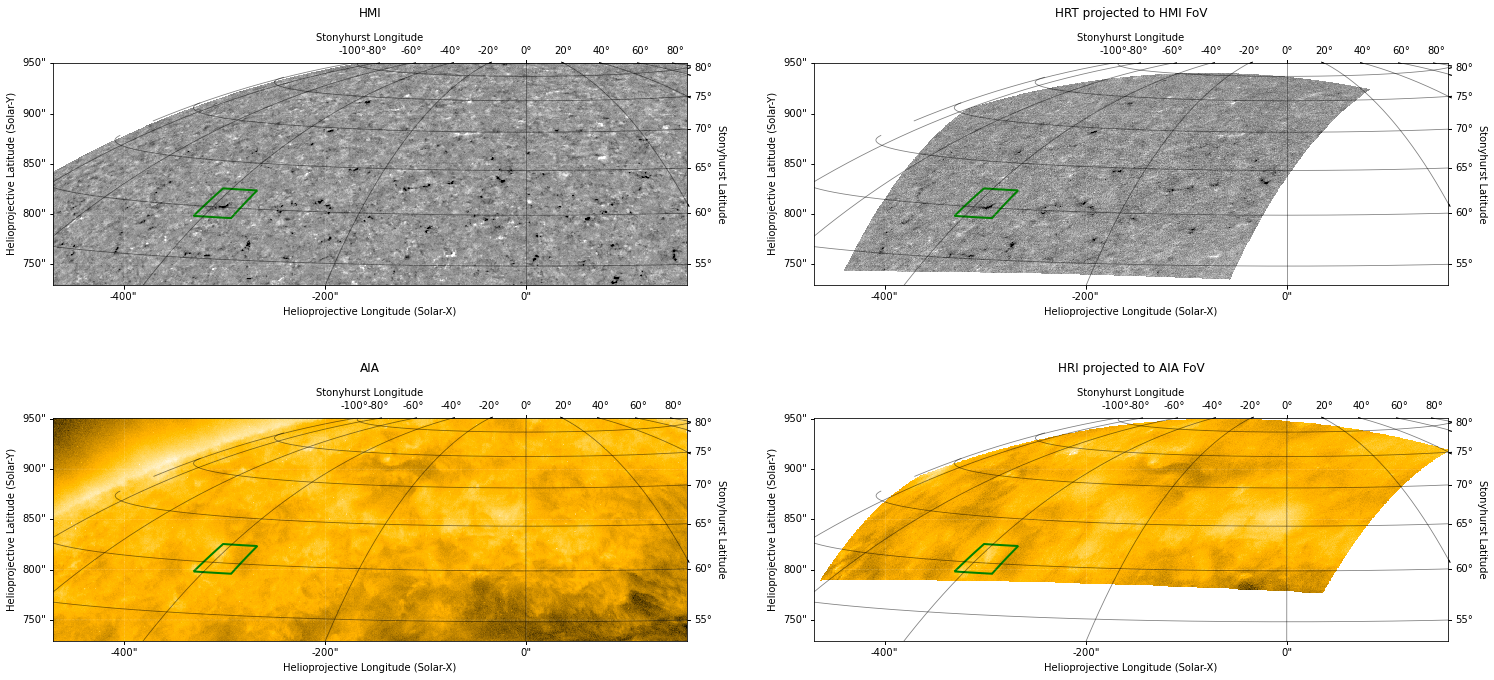

In [17]:
lat, lon = 59, -41.5
height, width = 3, 5.5

bottom_left= SkyCoord(lon = lon * u.deg, lat = lat * u.deg, frame= HeliographicStonyhurst) #we calculate the bottom left point and then we decide the width and height. Frame should be Stonyhurst
top_right = SkyCoord(lon = (lon + width)* u.deg, lat = (lat +  height) * u.deg, frame= HeliographicStonyhurst)
fig = plt.figure(figsize = (25,12))

ax = fig.add_subplot(221, projection = hmi_submap)
hmi_submap.plot()
hmi_submap.draw_quadrangle(bottom_left, axes=ax, width=width*u.deg, height=height*u.deg,
                    edgecolor= "green", linewidth=2)
hmi_submap.draw_grid(grid_spacing=(20, 5)* u.deg, color = "black")
plt.title("HMI", y = 1.18)

ax2 = fig.add_subplot(222, projection = hrt_reprojected_hmi_submap)
hrt_reprojected_hmi_submap.plot()
hrt_reprojected_hmi_submap.draw_quadrangle(bottom_left, axes=ax2, width=width*u.deg, height=height*u.deg,
                    edgecolor= "green", linewidth=2)
hrt_reprojected_hmi_submap.draw_grid(grid_spacing=(20, 5)* u.deg, color = "black")
plt.title("HRT projected to HMI FoV", y = 1.18)

ax3 = fig.add_subplot(223, projection = aia_submap)
aia_submap.plot()
aia_submap.draw_quadrangle(bottom_left, axes=ax3, width=width*u.deg, height=height*u.deg,
                    edgecolor= "green", linewidth=2)
aia_submap.draw_grid(grid_spacing=(20, 5)* u.deg, color = "black")
plt.title("AIA", y = 1.18)

ax4 = fig.add_subplot(224, projection = hri_reprojected_aia_submap)
hri_reprojected_aia_submap.plot()
hri_reprojected_aia_submap.draw_quadrangle(bottom_left, axes=ax4, width=width*u.deg, height=height*u.deg,
                    edgecolor= "green", linewidth=2)
hri_reprojected_aia_submap.draw_grid(grid_spacing=(20, 5)* u.deg, color = "black")
plt.title("HRI projected to AIA FoV", y = 1.18)

Now we crop each area and plot them alongside. We use the same Skycoord object in Stonyhurst

Text(0.5, 1.18, 'HRI selected area projected to AIA FoV')

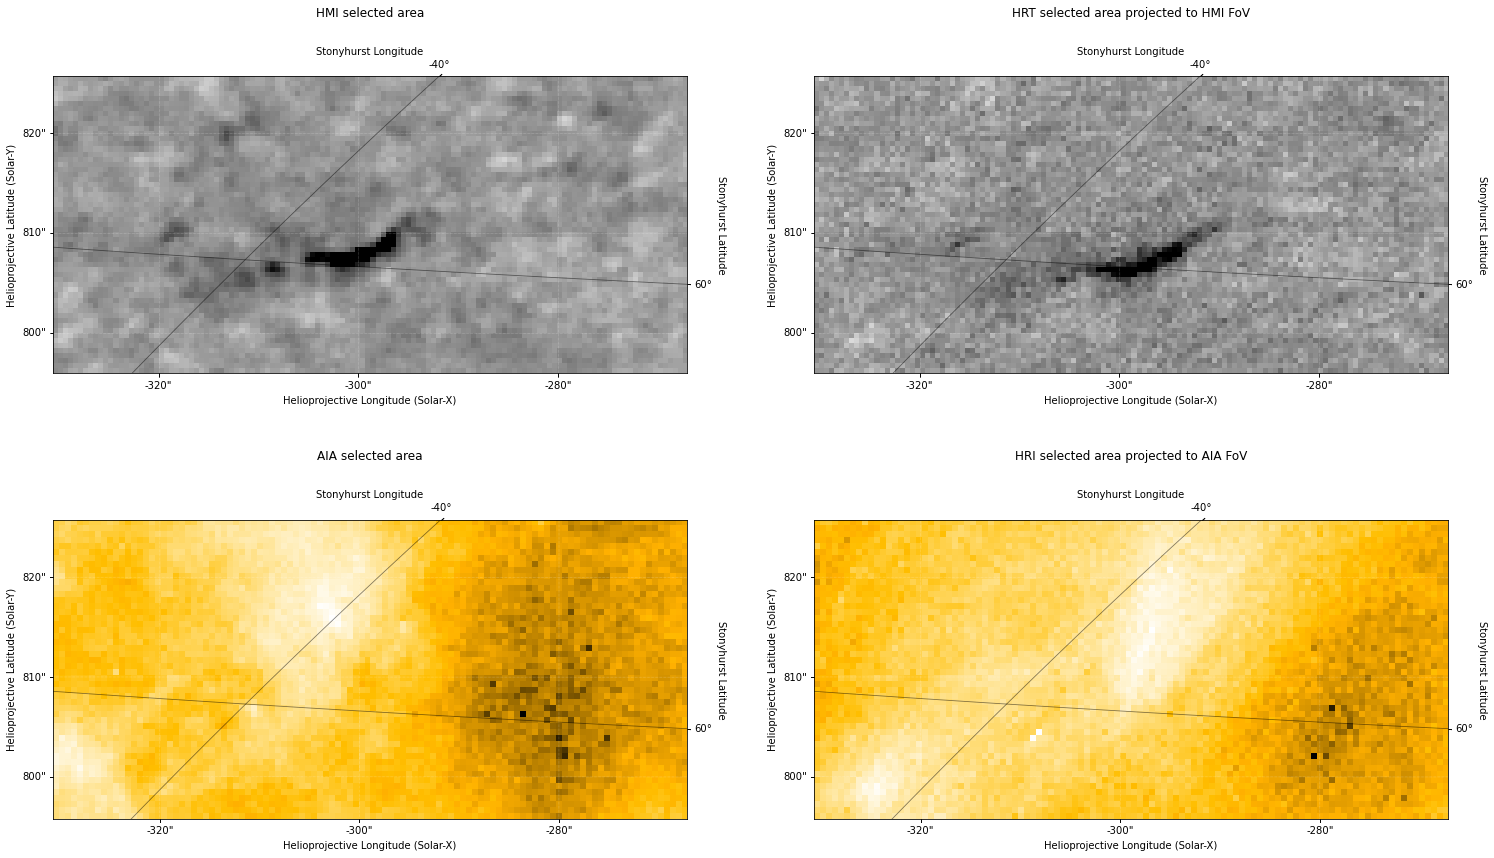

In [18]:
hmi_area = hmi_submap.submap(bottom_left, top_right = top_right)
hrt_area = hrt_reprojected_hmi_submap.submap(bottom_left, top_right = top_right)
aia_area = aia_submap.submap(bottom_left, top_right = top_right)
hri_area = hri_reprojected_aia_submap.submap(bottom_left, top_right = top_right)

fig = plt.figure(figsize = (25,15))

ax = fig.add_subplot(221, projection = hmi_area)
hmi_area.plot()
hmi_area.draw_grid(grid_spacing=(20, 5)* u.deg, color = "black")
plt.title("HMI selected area", y = 1.18)

ax2 = fig.add_subplot(222, projection = hrt_area)
hrt_area.plot()
hrt_area.draw_grid(grid_spacing=(20, 5)* u.deg, color = "black")
plt.title("HRT selected area projected to HMI FoV", y = 1.18)

ax3 = fig.add_subplot(223, projection = aia_area)
aia_area.plot()
aia_area.draw_grid(grid_spacing=(20, 5)* u.deg, color = "black")
plt.title("AIA selected area", y = 1.18)

ax2 = fig.add_subplot(224, projection = hri_area)
hri_area.plot()
hri_area.draw_grid(grid_spacing=(20, 5)* u.deg, color = "black")
plt.title("HRI selected area projected to AIA FoV", y = 1.18)

### FDT resampling to HMI resolution

First, we need to reprojecto FDT to the HMI's FoV (or correct FDT by distance)

In [19]:
#Read Data. I will use 45s HMI data
hmi_los_path = data_dir +  "/hmi.M_45s.20220203_003000_TAI.2.magnetogram.fits"
fdt_path = data_dir +  "/solo_L2_phi-fdt-blos_20220203T003009_V202205242205_0242030501.fits"

hmi_los_data, hmi_los_header = fits.getdata(hmi_los_path, header = True)
fdt_data, fdt_header = fits.getdata(fdt_path, header = True)

hmi_los_map = sunpy.map.Map(hmi_los_data, hmi_los_header).rotate()
fdt_map = sunpy.map.Map(fdt_data, fdt_header).rotate()

#Rotate FDT onto HMI plane
#As I explained before
repro_header = sunpy.map.make_fitswcs_header(
    fdt_map.data.shape,
    hmi_los_map.reference_coordinate.replicate(rsun=fdt_map.reference_coordinate.rsun),
    scale=u.Quantity(fdt_map.scale),
    instrument="PHI",
    observatory="HMI Observer"
                                          )

Reprojection algorithm

In [20]:
fdt_reprojected_hmi = fdt_map.reproject_to(repro_header, algorithm = "adaptive")

Now we plot the reprojected FDT map alongside the original HMI map. Despite the small angle between SDO and Solar Orbiter, the reprojected FDT image does not fill the full solar disk as seen on HMI (due to their different observation viewpoints).

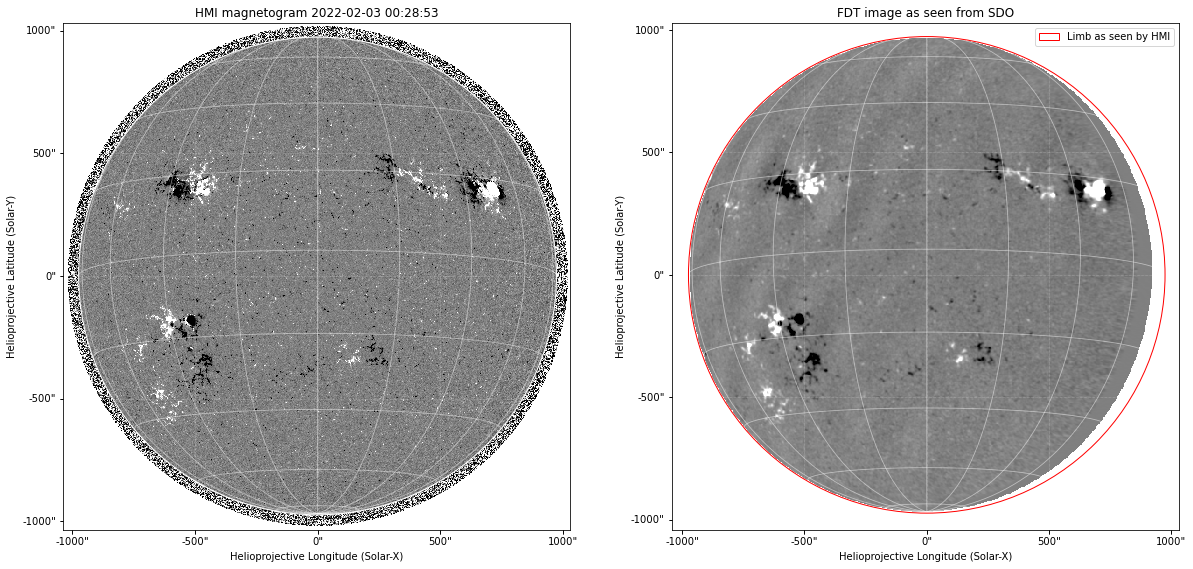

In [21]:
fig = plt.figure(figsize = (20,20))

ax1 = fig.add_subplot(121, projection= hmi_los_map)

hmi_los_map.plot(axes=ax1, clim = (-100,100))

hmi_los_map.draw_limb()
hmi_los_map.draw_grid(grid_spacing = 20 * u.deg)
# fdt_limb = fdt_map.draw_limb(color = "red", axes=ax1)


ax2 = fig.add_subplot(122, projection= fdt_reprojected_hmi)

fdt_reprojected_hmi.plot(axes=ax2, title='FDT image as seen from SDO', autoalign = True, clim = (-100,100))

fdt_reprojected_hmi.draw_limb()
fdt_reprojected_hmi.draw_grid(grid_spacing = 20 * u.deg)
hmi_limb = hmi_los_map.draw_limb(color = "red", axes=ax2)

ax2.set_xlim(420,1000)
ax2.set_ylim(420,1000)

plt.legend([hmi_limb[0]],
           ['Limb as seen by HMI'], loc = "upper right")

### Resampling HMI to FDT resolution

HMI's resolution is larger than the FDT one. To make both comparable we use the routine resample of Sunpy.

In [22]:
#First we print the pixel size of both maps

print(hmi_los_map.meta['CDELT1'], hmi_los_map.meta['CDELT2'])
print(fdt_map.meta['CDELT1'], fdt_map.meta['CDELT2'])

0.504021466 0.504021466
3.574 3.574


HMI is 7 times smaller, we need to downgrade the resolution. First, we crop both maps to have a submap of each instrument with exactly the same axis limits. In this case, we will create submaps from -1000 to 1000 arcsec in X and Y axis

In [23]:
xmin, xmax = -1000, 1000
ymin, ymax = -1000, 1000

#First the HMI map
top_right_HMI = SkyCoord(xmax * u.arcsec, ymax * u.arcsec, frame=hmi_los_map.coordinate_frame)
bottom_left_HMI = SkyCoord(xmin  * u.arcsec, ymin * u.arcsec, frame=hmi_los_map.coordinate_frame)

hmi_submap = hmi_los_map.submap(bottom_left_HMI, top_right = top_right_HMI)

#Then the FDT map that previously we reprojected to HMI's FoV
top_right_FDT = SkyCoord(xmax * u.arcsec, ymax * u.arcsec, frame=fdt_reprojected_hmi.coordinate_frame)
bottom_left_FDT = SkyCoord(xmin  * u.arcsec, ymin * u.arcsec, frame=fdt_reprojected_hmi.coordinate_frame)

fdt_reprojected_hmi_submap = fdt_reprojected_hmi.submap(bottom_left_FDT, top_right = top_right_FDT)

Now, we use the resample routine to make equal both resolutions

In [24]:
#The final dimension should be the same as the FDT map
hmi_submap_resampled = hmi_submap.resample(dimensions = (fdt_reprojected_hmi_submap.meta['NAXIS1'], fdt_reprojected_hmi_submap.meta['NAXIS2']) * u.pix, method = "linear") #nearest, linear or spline


#Now we compare the axis and pixel size between both maps, it is the same :)
print(np.shape(hmi_submap_resampled.data), np.shape(fdt_reprojected_hmi_submap.data))
print(hmi_submap_resampled.meta["CDELT1"], hmi_submap_resampled.meta["CDELT2"])
print(fdt_map.meta["CDELT1"], fdt_map.meta["CDELT2"])

(560, 560) (560, 560)
3.572252140275 3.5731521786071427
3.574 3.574


Now we are going to select the same area on both maps and plot it

Text(0.5, 0, 'Helioprojective Longitude (Solar - X)')

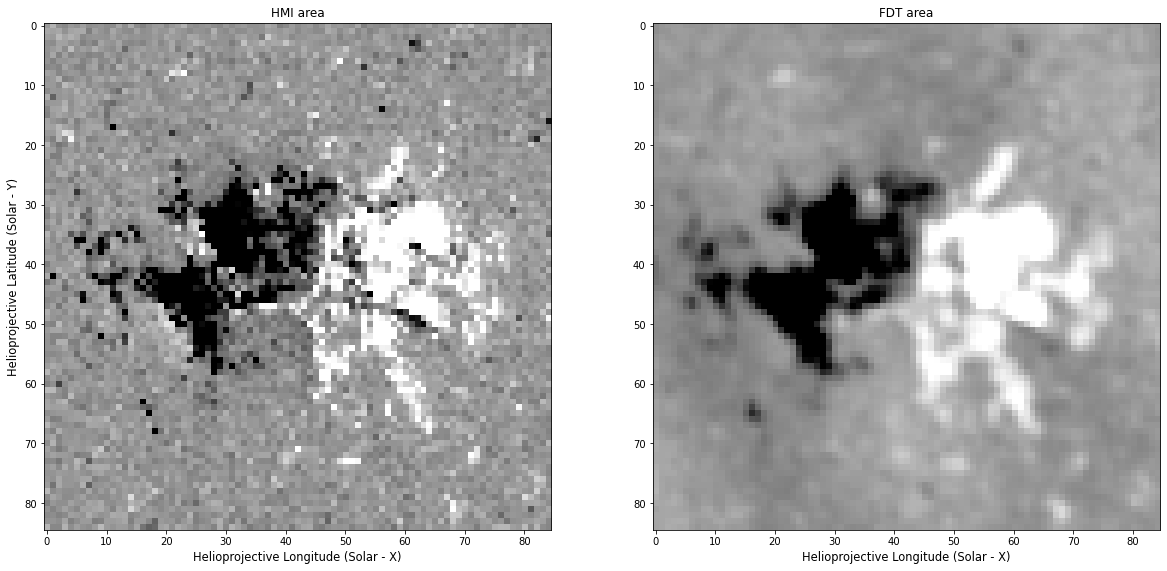

In [25]:
ymin, ymax = 220, 520
xmin, xmax = -680, -380
 
#Now we crop the maps to cut-out the selected area
    
top_right = SkyCoord(xmax * u.arcsec, ymax * u.arcsec, frame=hmi_submap_resampled.coordinate_frame)
bottom_left = SkyCoord(xmin  * u.arcsec, ymin * u.arcsec, frame=hmi_submap_resampled.coordinate_frame)

hmi_area = hmi_submap_resampled.submap(bottom_left, top_right = top_right)

top_right = SkyCoord(xmax * u.arcsec, ymax * u.arcsec, frame=fdt_reprojected_hmi_submap.coordinate_frame)
bottom_left = SkyCoord(xmin  * u.arcsec, ymin * u.arcsec, frame=fdt_reprojected_hmi_submap.coordinate_frame)

fdt_area = fdt_reprojected_hmi_submap.submap(bottom_left, top_right = top_right)

fig = plt.figure(figsize = (20,20))

ax = fig.add_subplot(121)

plt.imshow(hmi_area.data, cmap='Greys_r', clim = (-100,100))
ax.set_title('HMI area')

ax2 = fig.add_subplot(122)
plt.imshow(fdt_area.data, cmap='Greys_r', clim = (-100,100))
ax2.set_title("FDT area")


ax.set_ylabel('Helioprojective Latitude (Solar - Y)', fontsize = 11.5)
ax.set_xlabel('Helioprojective Longitude (Solar - X)', fontsize = 11.5)

ax2.set_ylabel(' ', fontsize = 11.5)
ax2.set_xlabel('Helioprojective Longitude (Solar - X)', fontsize = 11.5)

### Create Carrington Maps

We are goign to create Carrington maps with the FDT and HMI data

In [26]:
#First, we need to create the headers

from sunpy.map.header_helper import make_heliographic_header
shape = (720 * 1, 1440 * 1) #This is the final resolution of your map, bigger shape means lower computational time
carr_header_fdt = make_heliographic_header(fdt_map.date, fdt_map.observer_coordinate, shape, frame='carrington')
carr_header_hmi = make_heliographic_header(hmi_los_map.date, hmi_los_map.observer_coordinate, shape, frame='carrington')

Now we create the Carrington maps using reproject_to

In [27]:
carrington_map_phi = fdt_map.reproject_to(carr_header_fdt)
carrington_map_hmi = hmi_los_map.reproject_to(carr_header_hmi)

Now we plot them

Text(0.5, 1.05, 'HMI Carrington map')

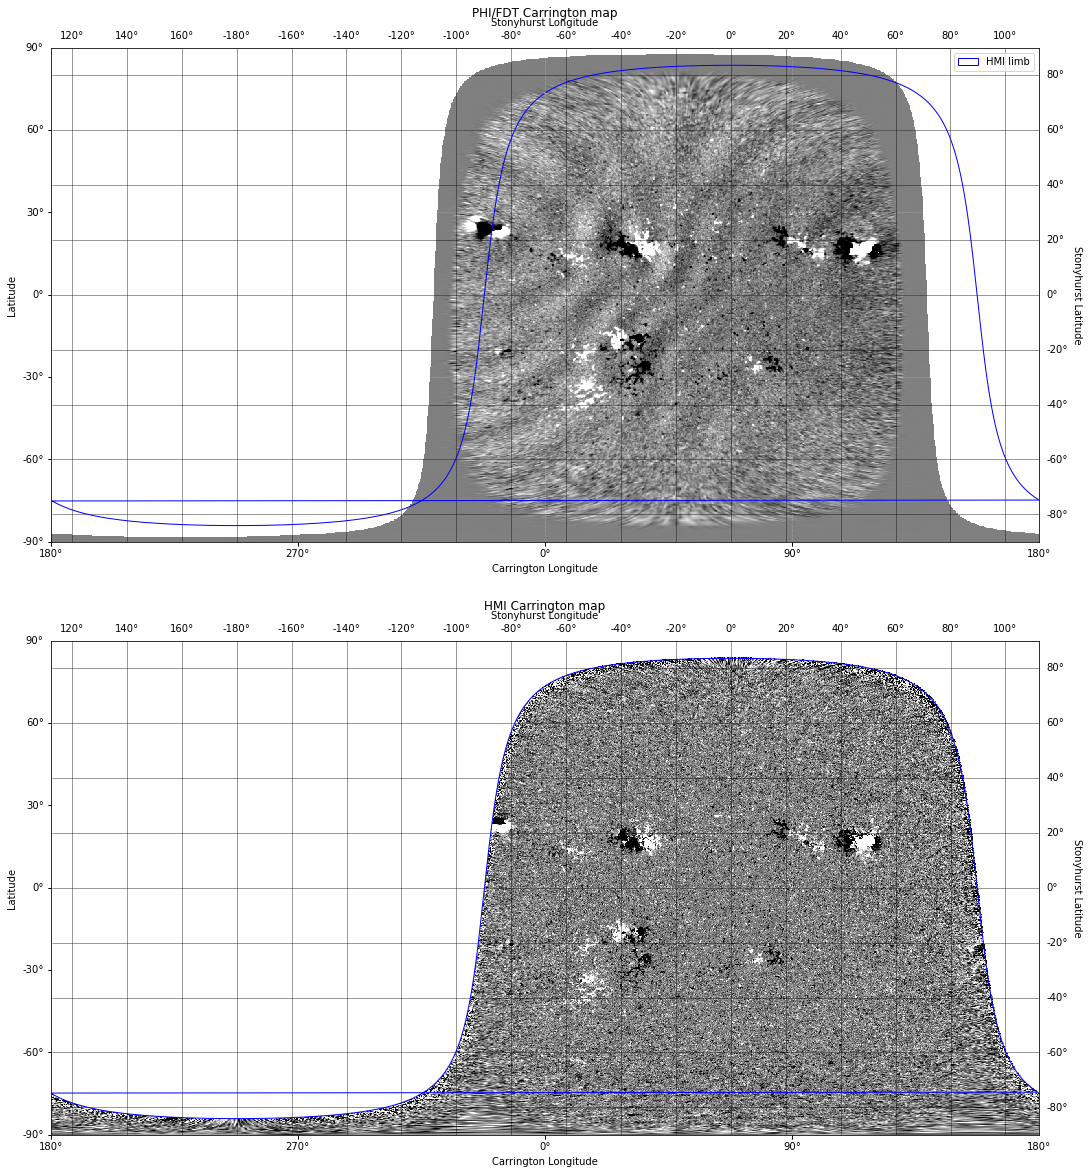

In [28]:
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(211, projection=carrington_map_phi)
carrington_map_phi.plot(axes=ax1, clim = (-30,30))
carrington_map_phi.draw_grid(color = "black", grid_spacing = 20 * u.deg)
carrington_map_hmi.draw_limb(color = "blue", label = "HMI limb")
plt.title('PHI/FDT Carrington map', y = 1.05)

plt.legend(loc = "upper right")

ax2 = fig.add_subplot(212, projection=carrington_map_hmi, sharex = ax1, sharey = ax1)
carrington_map_hmi.plot(axes=ax2, clim = (-30,30))
carrington_map_hmi.draw_limb(color='blue')
carrington_map_hmi.draw_grid(color = "black", grid_spacing = 20 * u.deg)
plt.title('HMI Carrington map', y = 1.05)



### Save fits files

We will use fits.writeto. We also need to create correctly the header of the maps, for that we use Hader from astropy fits

In [29]:
from astropy.io.fits import Header
header_phi = Header(carrington_map_phi.meta)
header_hmi = Header(carrington_map_hmi.meta)

fits.writeto(data_dir + "carrington_map_hmi.fits" , carrington_map_hmi.data, header_phi, overwrite=True)
fits.writeto(data_dir + "carrington_map_phi.fits", carrington_map_phi.data, header_hmi, overwrite=True)

